In [25]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings 
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


def read_in_data():
    """
    Reads in our collected BTC csv into a pandas data frame and removes all other columns other than the close price
    
    :param - 
    :returns - Pandas data frame containing the close price indexed by time
    """
    data_frame = pd.DataFrame()
    file = "BTCPRICE.csv"
    data_frame = pd.read_csv(file, names=["time", "open", "high", "low", "close", "volume"])
    data_frame.set_index("time", inplace = True)
    data_frame = data_frame[["close"]]     
    return data_frame

In [26]:
def run_adf_test(df):
    """
    Runs an ADF(augmented dickey fuller) test to determine our data set has a unit root and if the series is stationary
    This test makes use of a null hypothesis: The series has a unit root value of 1
    if the null hypothesis is not reject this then measn that our data seet is non-stationary
    :param - 
    :returns - 
    """
    test_result = adfuller(df.close.dropna())
    print("ADF_test Statistic value: ", test_result[0])
    print("ADF_test P value: ", test_result[1])

In [27]:
def create_train_test_set(df):
    """
    This method takes in our data frame and seperates our close price list into training and testing sets at a ratio of 80/20
    :param - df data frame
    :returns - train, test
    """
    array = np.log(df.close)
    length = int(len(df)*0.8)
    train = array[:length]
    test = array[length:]
    
    return train, test

In [28]:
def run_auto_arima(train):
    """
    Here we run the auto arima to find the optimal parameters to insert into our model
    :param - train
    :returns - order - optimal parameters
    """
    model = auto_arima(train, max_p=4, max_q=4, 
                       start_q=0, start_p=0, 
                       start_P=0, start_Q=0,
                       D=0, test='adf', seasonal=False,
                       trace=True, error_action='ignore', 
                       suppress_warnings=True, stepwise=True) 
    print(model.summary())  
    order = model.order
    return order

In [29]:
def run_arima_model(train, order):
    """
    We fit our arima model to our data using our optimal parameters
    :param - train, order
    :returns - result
    """
    model = ARIMA(train, order=order)  
    result = model.fit(disp=-1)
    print(result.summary())
    return result

In [30]:
def forecast_model(result, test, train):
    """
    Using our generated optimal model we then create a forcast using our test data and plot it against the real BTC price
    :param - train, order
    :returns - result
    """
    fc, se, conf = result.forecast(1608,alpha=0.05) 
    print(fc)
    fc = pd.Series(fc, index=test.index)
    series_one = pd.Series(conf[:, 0], index=test.index)
    series_two = pd.Series(conf[:, 1], index=test.index)
    
    plt.figure(figsize=(16,8))
    plt.plot(train, color = 'green')
    plt.plot(test, color = 'green', label='Real BTC Price')
    plt.plot(fc, color = 'purple',label='Predicted BTC Price')
    plt.fill_between(series_one.index, series_one, series_two, color='k', alpha=.10)
    plt.title('BTC PRICE PREDICTION')
    plt.xlabel('Time')
    plt.ylabel('BTC PRICE')
    plt.legend(loc='upper left')
    plt.show()

In [31]:
df = read_in_data()
run_adf_test(df)
train, test = create_train_test_set(df)
order = run_auto_arima(train)
result = run_arima_model(train, order)

ADF_test Statistic value:  0.17732554110180296
ADF_test P value:  0.9709607907613236
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-40445.353, Time=0.88 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40473.282, Time=1.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-40473.582, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-40445.949, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-40471.582, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-40471.573, Time=0.74 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-40469.631, Time=3.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-40473.963, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-40471.963, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-40471.951, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-40473.675, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-40469.996, Time=0.76 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit

C:\uni_installs\Conda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\uni_installs\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecast

[5.84852998 5.84868376 5.84883754 ... 6.09534419 6.09549797 6.09565175]


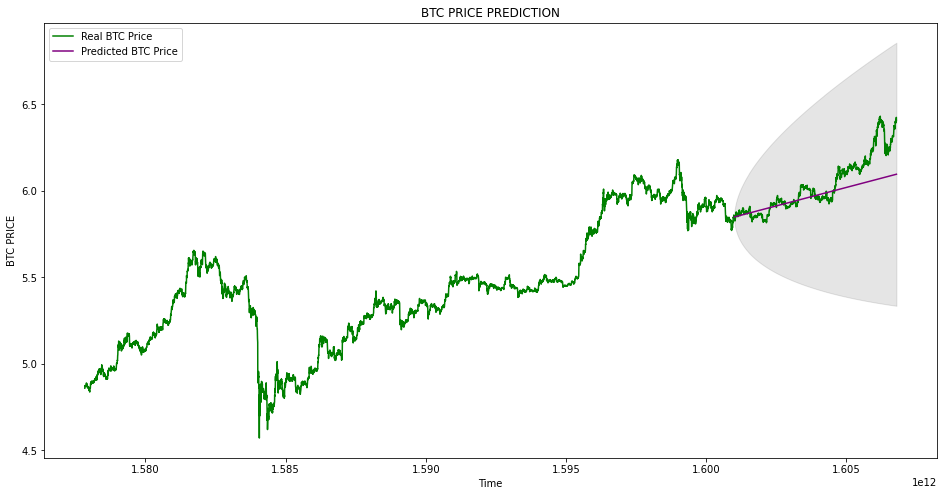

In [32]:
forecast_model(result, test, train)